# Anomaly Detection Using Autoencoders

The goal of this project is to detect anomalies on the desired dataset using an autoencoder architecture. For this architecture, the number of nodes, layers and type of layers will be varied to achieve the best result.

Because of the high dimensionality of the dataset, PCA will be used for dimensionality reduction, applying the autoenconder to the most important principal components. Later, using the correlation of the columns with the most important principal component, it will be possible to plot some of the columns and it's reconstructions, marking the anomalies for later analysis.

## Imports

In [1]:
cd ../../

/mnt/c/Users/victo/Documents/Repos/neural-networks


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras import regularizers

In [3]:
from utils.data_manipulation import Data
from utils.data_visualization import DataViz

## The Dataset

The choosen dataset is located in this link: https://www.kaggle.com/nphantawee/pump-sensor-data.
It's a collection of 52 sensors that monitorates a water pump machine. This sensors are all float values and can indicate anomalies and breakage of the pump. To aid on this detection, there is a column "machine_status", marking if the pump is broken, recovering or running.

In [4]:
pump_data = pd.read_csv("datasets/sensor.csv", sep=",")
pump_data.reset_index(drop=True, inplace=True)
pump_data = pump_data.drop(["Unnamed: 0"], axis=1)
display(pump_data)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


### Fix missing values

Fill null fields with the mean value of the column and remove invalid columns.

In [5]:
pump_data = pump_data.fillna(pump_data.mean())
pump_data = pump_data.drop(["sensor_15"], axis=1)

### Plot of a Sensor Data and Breakage Points

Timeseries plotting of the sensor #0 and #1, with the breakage points highlited as red dots.

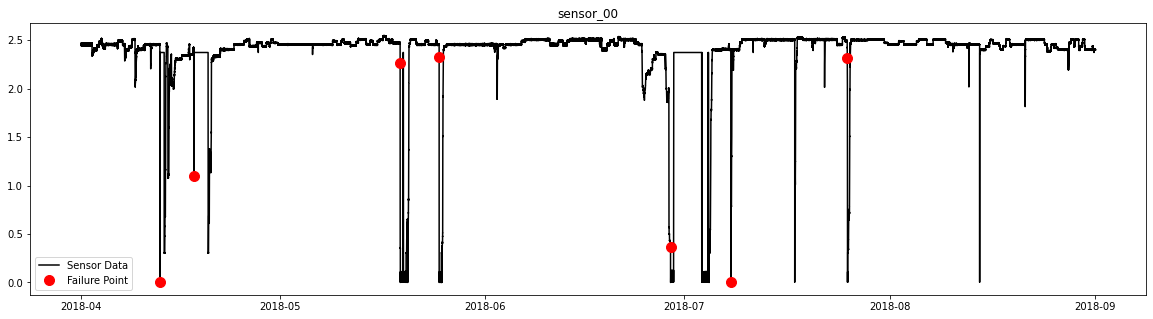

In [6]:
pd.options.mode.chained_assignment = None
# plt.rcParams.update({'font.size': 22})

broken_markers = pump_data[pump_data["machine_status"] == "BROKEN"]
broken_markers["timestamp"] = pd.to_datetime(broken_markers["timestamp"])
timestamps = list(pd.to_datetime(pump_data["timestamp"]).to_numpy())
pump_data_sensors_only = pump_data.drop(["machine_status", "timestamp"], axis=1)
plt.figure(figsize=(20,5))
plt.plot(timestamps, pump_data_sensors_only["sensor_00"], color="black", label="Sensor Data")
plt.plot(broken_markers["timestamp"], broken_markers["sensor_00"], linestyle='none', marker='o', color='red', markersize=10, label="Failure Point")
plt.title("sensor_00")
plt.legend()
plt.show()

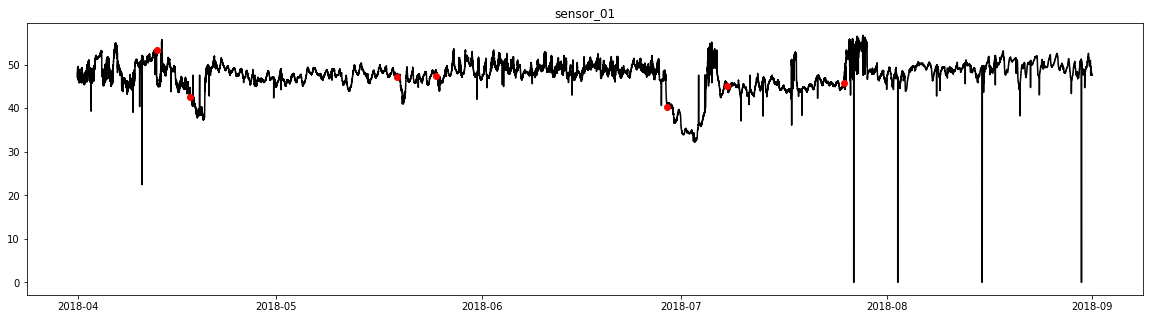

In [7]:
plt.figure(figsize=(20,5))
plt.plot(timestamps, pump_data_sensors_only["sensor_01"], color="black")
plt.plot(broken_markers["timestamp"], broken_markers["sensor_01"], linestyle='none', marker='o', color='red', markersize=6)
plt.title("sensor_01")
plt.show()

## Autoencoder Building

In [21]:
## TODO
### Normalize data
### Train with half dataset
### Test for the other half
### High loss = anomaly
### 

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def flatten_all(input_data):
    new_data = []
    for data in input_data:
        new_data.append(data.flatten())
    return np.array(new_data)

def create_model(input_dim, encoder_layer_details, decoder_layer_details, optimizer, loss="mean_squared_error", metrics=None):
    input_layer = [Input(shape=(input_dim,), name="input")]
    output_layer = [Dense(units=input_dim, activation="sigmoid", name="output")]
    
    layers = input_layer + encoder_layer_details + decoder_layer_details + output_layer
    model = tf.keras.Sequential(layers)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

# Trains the model
def run_model(model, epochs, batch_size, x_train, x_test):
    model_train = model.fit(
        x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        validation_data=(x_test, x_test))
    DataViz.plot_loss(
        model_train.history['loss'],
        model_train.history['val_loss'],
        range(epochs)
    )
    
def find_and_plot_anomalies(model, x_train, x_test, original_dataset, pump_status, broken_markers):
    # Find the max MSE loss during training and set it as the threshold for anomalies
    x_train_pred = model.predict(x_train)
    train_mse_loss = np.mean(np.square(np.abs(x_train_pred - x_train)), axis=1)

    plt.hist(train_mse_loss, bins=50)
    plt.xlabel("Train MSE loss")
    plt.ylabel("# of samples")
    plt.show()

    threshold = np.max(train_mse_loss)
    print("Anomaly MSE threshold: ", threshold)
    
    # Get the MSE loss for test samples and mark those which surpasses the loss threshold as anomalies
    x_test_pred = model.predict(x_test)
    test_mse_loss = np.mean(np.square(np.abs(x_test_pred - x_test)), axis=1)
    test_mse_loss = test_mse_loss.reshape((-1))

    plt.hist(test_mse_loss, bins=50)
    plt.xlabel("Test MSE loss")
    plt.ylabel("# of samples")
    plt.show()

    anomalies = test_mse_loss > threshold
    print("# of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    
    # Get the points that are considered anomalies on the original dataset
    anomaly_points = original_dataset[original_dataset.index.isin(np.where(anomalies)[0])]
    
    # Plot the test data with the anomalies marked
    plt.figure(figsize=(20,5))
    plt.plot(timestamps[part:], original_dataset["sensor_00"], color="black")
    plt.plot(broken_markers["timestamp"], broken_markers["sensor_00"], linestyle='none', marker='X', color='red', markersize=10)
    plt.plot(anomaly_points["timestamp"], anomaly_points["sensor_00"], linestyle='none', marker='o', color='blue', markersize=5)
    plt.title("sensor_00")
    plt.show()
    
    indexes = list(broken_markers.index)
    print(indexes)
    anomalies_indexes = list(np.where(anomalies)[0])
    total = len(anomalies_indexes)
    score = 0
    total_score = 0
    if total > 0:
        for break_point in indexes:
            for anomaly_index in anomalies_indexes:
                if (anomaly_index >= (break_point - 1440) and anomaly_index <= break_point) or (anomaly_index <= (break_point + 1440) and anomaly_index >= break_point):
                    score += 1
            partial_score = (100*(1/len(indexes)))*(score/total)
            print(partial_score)
            total_score += partial_score
            score = 0
    
    return total_score

x_data = flatten_all(normalize(pump_data_sensors_only.to_numpy()))
part = 5*int(len(x_data)/10)
x_train = np.array(x_data[:part])
x_test = np.array(x_data[part:])

input_shape = x_train[0].shape[0]

original_dataset = pd.DataFrame({"sensor_00": x_train[:, 0], "timestamp": timestamps[part:]})
pump_status = pump_data[part:].reset_index(drop=True)
pump_status = pump_status[["machine_status", "timestamp"]]
pump_status = pd.concat([pd.DataFrame({"sensor_00": x_train[:, 0]}), pump_status], axis=1)
broken_markers = pump_status[pump_status["machine_status"] == "BROKEN"]
broken_markers["timestamp"] = pd.to_datetime(broken_markers["timestamp"])

models = []

### Model 1

- 3 Hidden dense layers
- No other special aditions

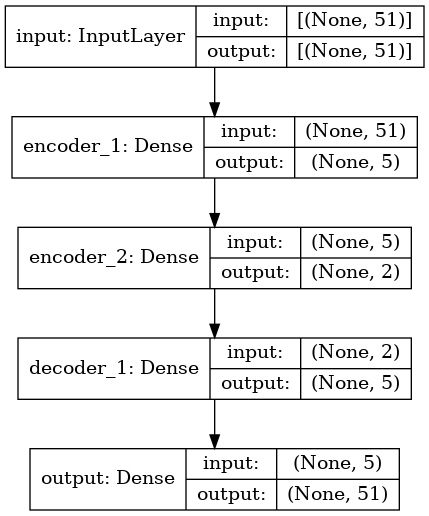

In [9]:
encoder_layer = [
    Dense(
        units=5,
        activation="relu",
#         activity_regularizer=regularizers.l2(1e-3),
        name="encoder_1"
    ),
    Dense(
        units=2,
        activation="relu",
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=5,
        activation="relu",
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 2s 2ms/step - loss: 0.0649 - val_loss: 0.0027
Epoch 2/80
861/861 [==============================] - 1s 932us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 3/80
861/861 [==============================] - 1s 918us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/80
861/861 [==============================] - 1s 913us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/80
861/861 [==============================] - 1s 900us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/80
861/861 [==============================] - 1s 909us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/80
861/861 [==============================] - 1s 904us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/80
861/861 [==============================] - 1s 905us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/80
861/861 [==============================] - 1s 910us/step - loss: 0.0013 - 

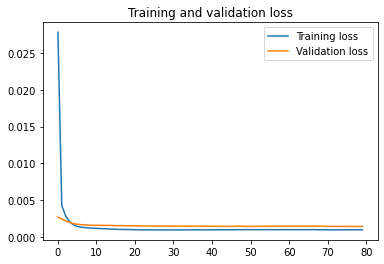

In [10]:
run_model(models[-1], 80, 128, x_train, x_test)

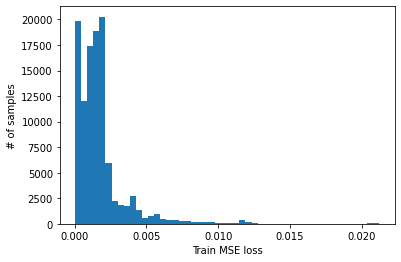

Anomaly MSE threshold:  0.02123234254085331


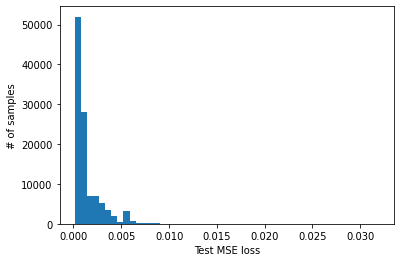

# of anomaly samples:  24
Indices of anomaly samples:  (array([17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564, 17826,
       17827, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835,
       17915, 17916, 17917, 17918, 17919, 17920]),)


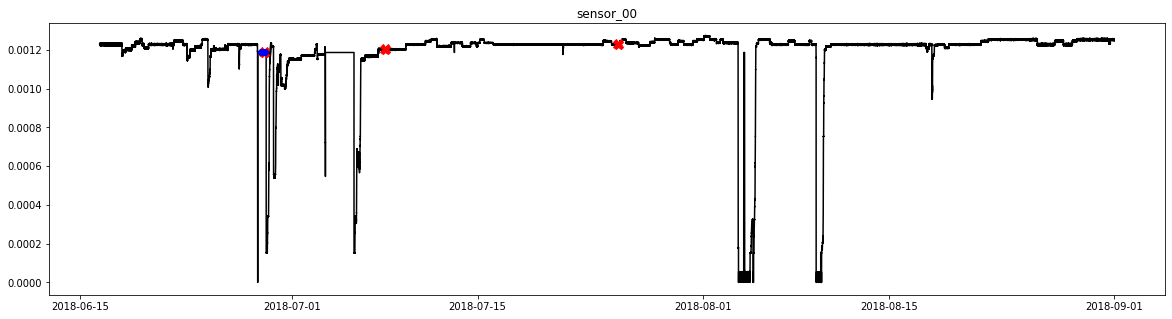

[17880, 30971, 56280]
33.33333333333333
0.0
0.0


33.33333333333333

In [11]:
score = find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)
score

### Model 2

- 3 hidden dense layers
- More neurons per layer

More anomalies detected, but poor generalization (high overfitting).

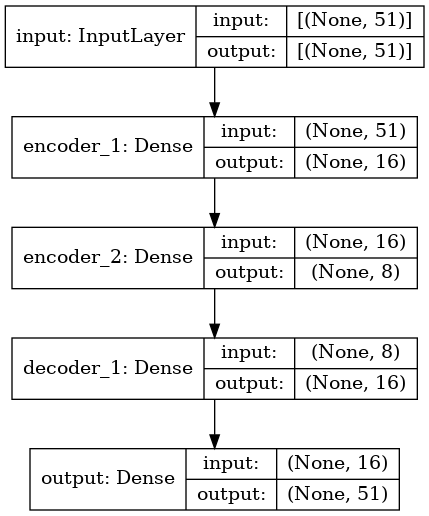

In [12]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        name="encoder_1"
    ),
    Dense(
        units=8,
        activation="relu",
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0434 - val_loss: 0.0027
Epoch 2/80
861/861 [==============================] - 1s 945us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 3/80
861/861 [==============================] - 1s 939us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/80
861/861 [==============================] - 1s 917us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/80
861/861 [==============================] - 1s 918us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/80
861/861 [==============================] - 1s 913us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/80
861/861 [==============================] - 1s 962us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 9/80
861/861 [==============================] - 1s 986us/step - loss: 9.9268e-04 - val_loss: 0.0015
Epoch 10/80
861/861 [==============================] - 1s 954us/step - loss: 9.821

861/861 [==============================] - 1s 907us/step - loss: 2.5564e-04 - val_loss: 0.0012
Epoch 79/80
861/861 [==============================] - 1s 910us/step - loss: 2.4316e-04 - val_loss: 0.0012
Epoch 80/80
861/861 [==============================] - 1s 895us/step - loss: 2.5635e-04 - val_loss: 0.0012


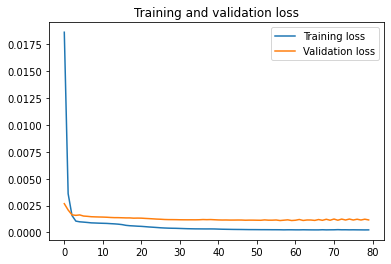

In [13]:
run_model(models[-1], 80, 128, x_train, x_test)

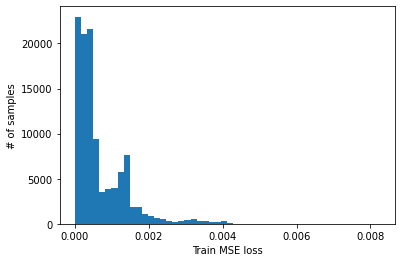

Anomaly MSE threshold:  0.008239984373784861


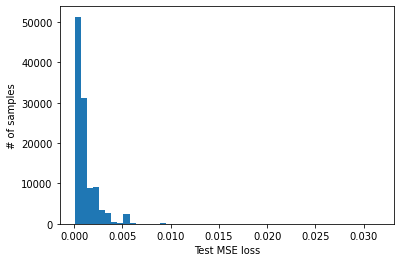

# of anomaly samples:  402
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 14267, 14268, 14269, 14270,
       15607, 15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615,
       15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624,
       15625, 15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633,
       15634, 15635, 15636, 15637, 15638, 15639, 15640, 15641, 15642,
       15643, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 17190,
       17191, 17192, 17203, 17204, 17205, 17209, 17210, 17213, 17214,
       17215, 17216, 17217, 17218, 17223, 17224, 17225, 17399, 17400,
       17401, 17402, 17403, 17430, 17431, 17432, 17433, 17447, 17448,
       17449, 17458, 17459, 17460, 17461, 17462, 17463, 17464, 17468,
       17469, 17470, 17471, 17472, 17473, 17481, 17482, 17483, 17484,
       17485, 17504, 17505, 17506, 17513, 17514, 17515, 17516, 17517,
       17518, 17519, 17524, 17525, 17526, 17527, 17546, 17547, 17548,
       17549, 17550, 17551, 17552

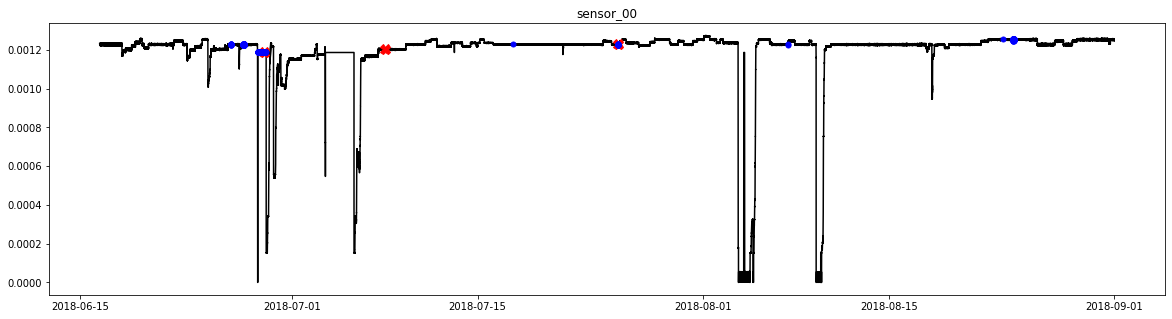

[17880, 30971, 56280]
23.13432835820895
0.0
0.8291873963515753


23.963515754560525

In [14]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 3

- 3 hidden dense layers
- Added regularization term l1 to reduce overfitting

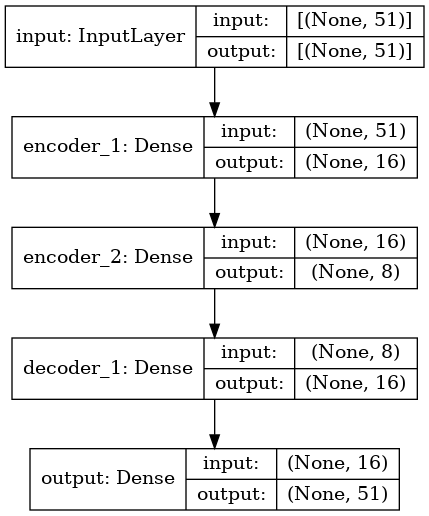

In [15]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0615 - val_loss: 0.0120
Epoch 2/80
861/861 [==============================] - 1s 983us/step - loss: 0.0117 - val_loss: 0.0075
Epoch 3/80
861/861 [==============================] - 1s 992us/step - loss: 0.0081 - val_loss: 0.0058
Epoch 4/80
861/861 [==============================] - 1s 981us/step - loss: 0.0063 - val_loss: 0.0047
Epoch 5/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 6/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 7/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 8/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 

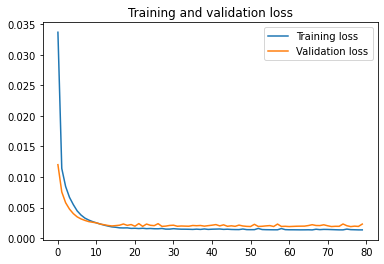

In [16]:
run_model(models[-1], 80, 128, x_train, x_test)

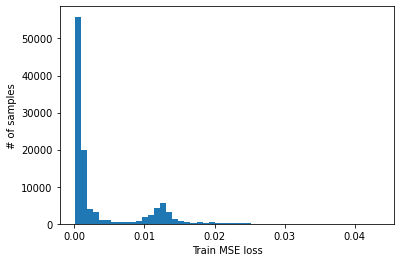

Anomaly MSE threshold:  0.043462405089026684


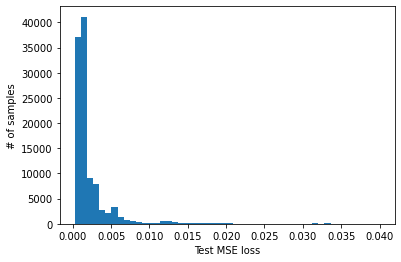

# of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


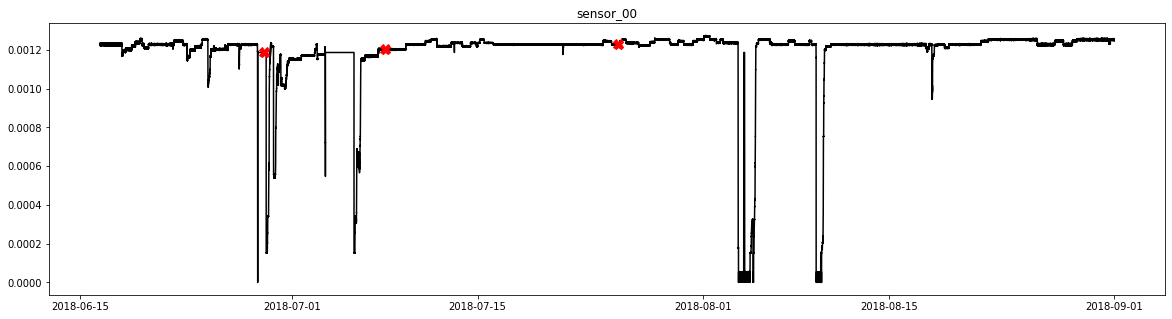

[17880, 30971, 56280]


0

In [22]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 4

- 3 hidden dense layers
- 2 dropout layers

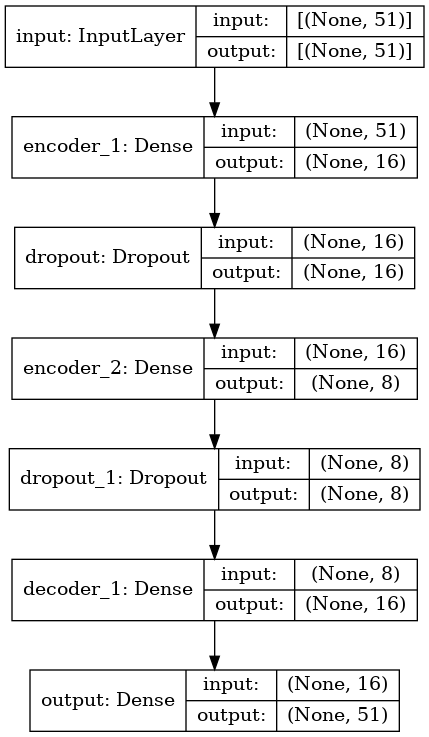

In [23]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
    Dropout(
        rate=0.3
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0450 - val_loss: 0.0029
Epoch 2/80
861/861 [==============================] - 1s 954us/step - loss: 0.0034 - val_loss: 0.0021
Epoch 3/80
861/861 [==============================] - 1s 939us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/80
861/861 [==============================] - 1s 938us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/80
861/861 [==============================] - 1s 933us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/80
861/861 [==============================] - 1s 936us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/80
861/861 [==============================] - 1s 938us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/80
861/861 [==============================] - 1s 955us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/80
861/861 [==============================] - 1s 947us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/80
861/861 [==============================] - 1s 991us/step - loss: 0.0013 

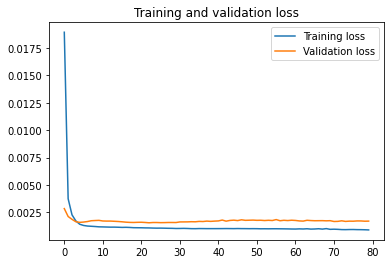

In [24]:
run_model(models[-1], 80, 128, x_train, x_test)

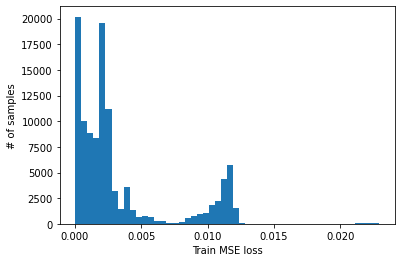

Anomaly MSE threshold:  0.022949919362859336


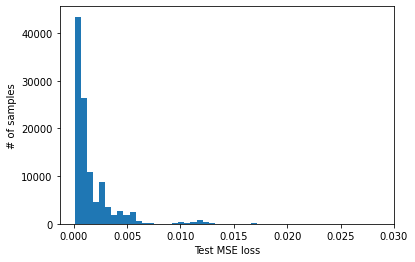

# of anomaly samples:  67
Indices of anomaly samples:  (array([17546, 17547, 17548, 17549, 17550, 17551, 17552, 17553, 17558,
       17559, 17560, 17561, 17562, 17563, 17564, 17726, 17727, 17728,
       17729, 17730, 17731, 17735, 17736, 17737, 17738, 17739, 17740,
       17760, 17761, 17762, 17765, 17766, 17767, 17768, 17769, 17770,
       17771, 17772, 17773, 17794, 17795, 17796, 17799, 17800, 17801,
       17802, 17803, 17804, 17805, 17828, 17829, 17830, 17831, 17832,
       17833, 17834, 17835, 17846, 17898, 17899, 17900, 17901, 17902,
       17903, 17905, 17908, 17909]),)


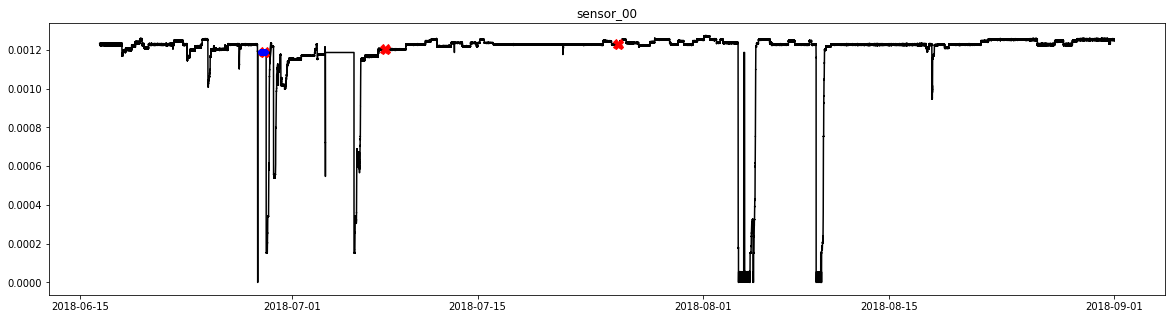

[17880, 30971, 56280]
33.33333333333333
0.0
0.0


33.33333333333333

In [25]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 5

- 3 hidden dense layers
- 4 dropout layers

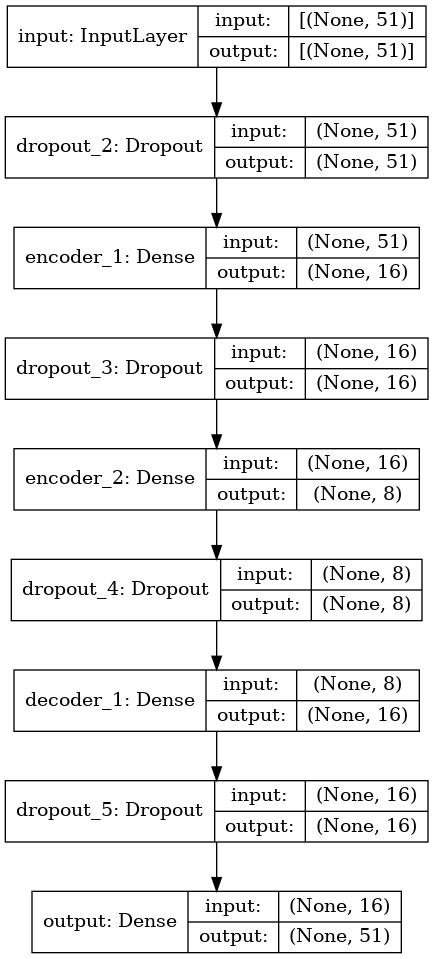

In [26]:
encoder_layer = [
    Dropout(
        rate=0.3
    ),
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
    Dropout(
        rate=0.3
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    ),
    Dropout(
        rate=0.3
    ),
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0490 - val_loss: 0.0027
Epoch 2/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 3/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0017

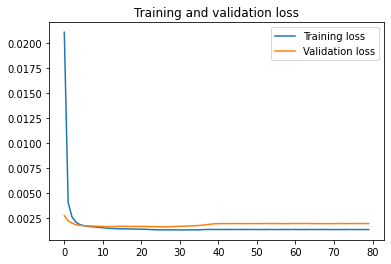

In [27]:
run_model(models[-1], 80, 128, x_train, x_test)

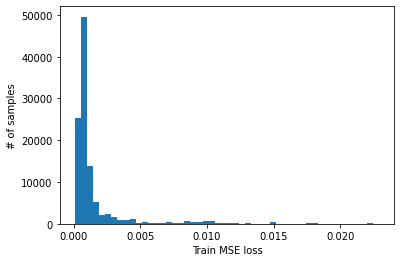

Anomaly MSE threshold:  0.02293138660970686


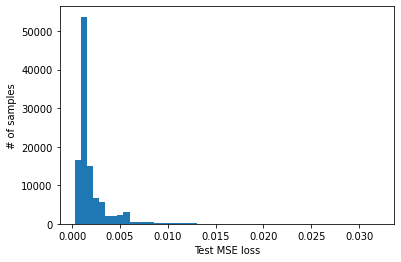

# of anomaly samples:  8
Indices of anomaly samples:  (array([17828, 17829, 17830, 17849, 17850, 17851, 17909, 17910]),)


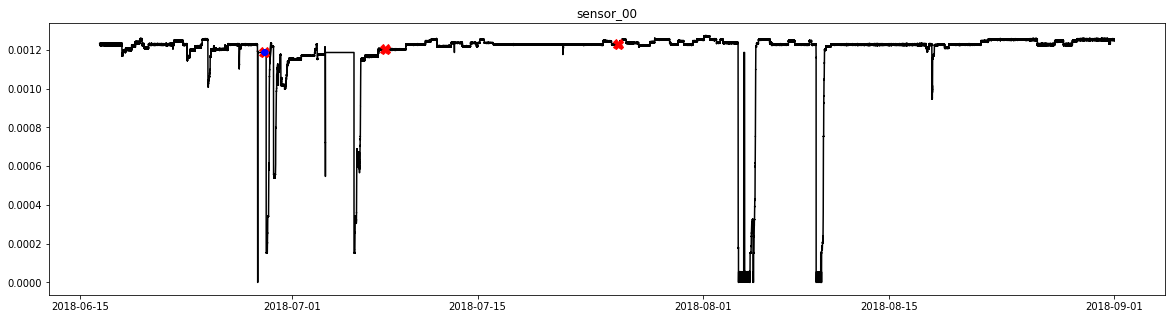

[17880, 30971, 56280]
33.33333333333333
0.0
0.0


33.33333333333333

In [28]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 6

- 3 hidden dense layers
- 2 dropout layers
- L1 regularization term

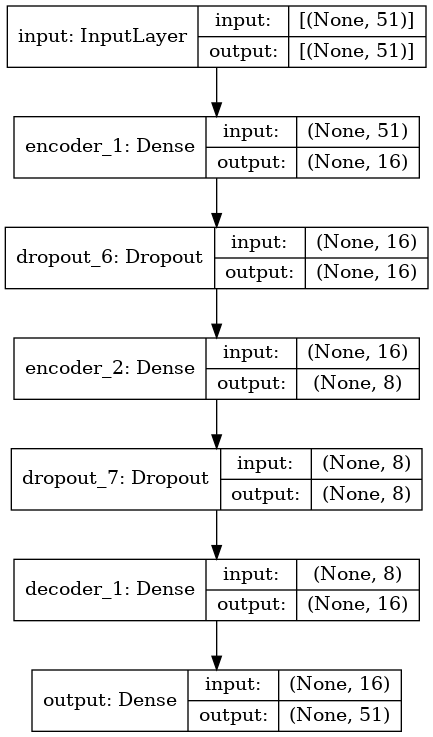

In [29]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
    Dropout(
        rate=0.3
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0077
Epoch 2/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 3/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 4/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 5/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 6/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 7/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0028

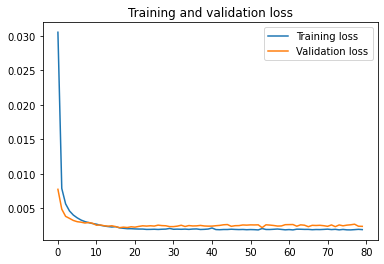

In [30]:
run_model(models[-1], 80, 128, x_train, x_test)

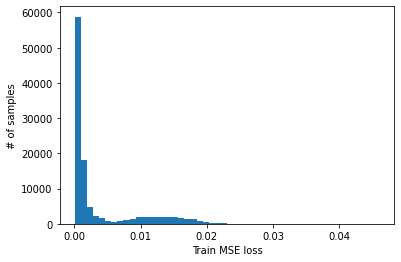

Anomaly MSE threshold:  0.04602257000015724


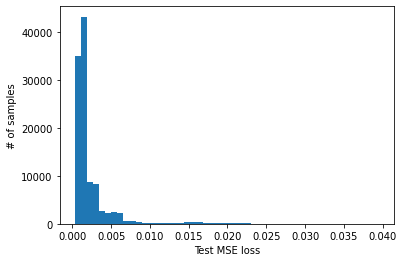

# of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


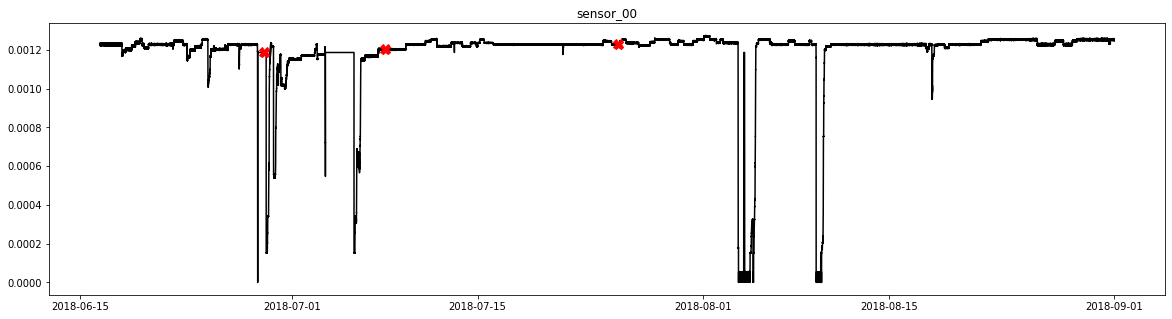

[17880, 30971, 56280]


0

In [31]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 7

- 1 hidden layer

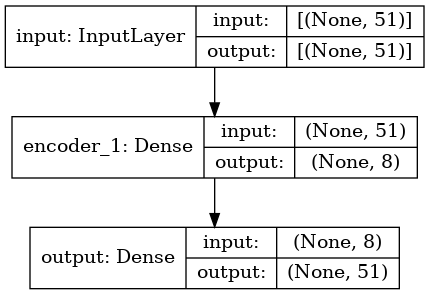

In [32]:
encoder_layer = [
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 975us/step - loss: 0.0536 - val_loss: 0.0031
Epoch 2/80
861/861 [==============================] - 1s 790us/step - loss: 0.0057 - val_loss: 0.0027
Epoch 3/80
861/861 [==============================] - 1s 772us/step - loss: 0.0043 - val_loss: 0.0024
Epoch 4/80
861/861 [==============================] - 1s 772us/step - loss: 0.0032 - val_loss: 0.0019
Epoch 5/80
861/861 [==============================] - 1s 913us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/80
861/861 [==============================] - 1s 780us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/80
861/861 [==============================] - 1s 778us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/80
861/861 [==============================] - 1s 834us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/80
861/861 [==============================] - 1s 853us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/80
861/861 [==============================] - 1s 846us/step - loss: 9.786

Epoch 78/80
861/861 [==============================] - 1s 885us/step - loss: 3.0441e-04 - val_loss: 0.0011
Epoch 79/80
861/861 [==============================] - 1s 848us/step - loss: 3.0371e-04 - val_loss: 0.0011
Epoch 80/80
861/861 [==============================] - 1s 871us/step - loss: 3.0297e-04 - val_loss: 0.0011


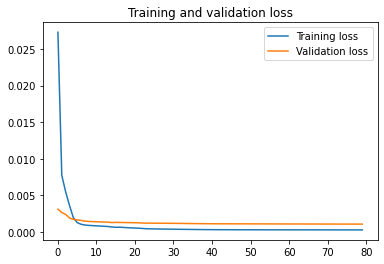

In [33]:
run_model(models[-1], 80, 128, x_train, x_test)

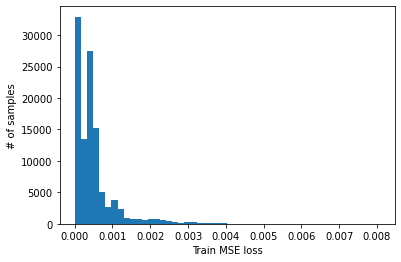

Anomaly MSE threshold:  0.008060928685095736


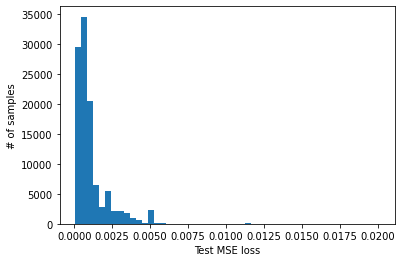

# of anomaly samples:  279
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 14267, 15605, 15606, 15607,
       15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615, 15616,
       15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625,
       15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633, 15634,
       15635, 15636, 15637, 15638, 15639, 15640, 15641, 15642, 15643,
       15644, 15645, 15646, 15647, 15648, 15649, 15650, 17190, 17191,
       17192, 17203, 17204, 17205, 17209, 17210, 17214, 17215, 17216,
       17217, 17218, 17224, 17225, 17399, 17400, 17401, 17402, 17403,
       17430, 17431, 17432, 17433, 17447, 17448, 17449, 17458, 17459,
       17460, 17461, 17462, 17463, 17464, 17468, 17469, 17470, 17471,
       17472, 17473, 17481, 17482, 17483, 17484, 17485, 17504, 17505,
       17506, 17513, 17514, 17515, 17516, 17517, 17518, 17519, 17524,
       17525, 17526, 17527, 17546, 17547, 17548, 17549, 17550, 17551,
       17552, 17553, 17557, 17558

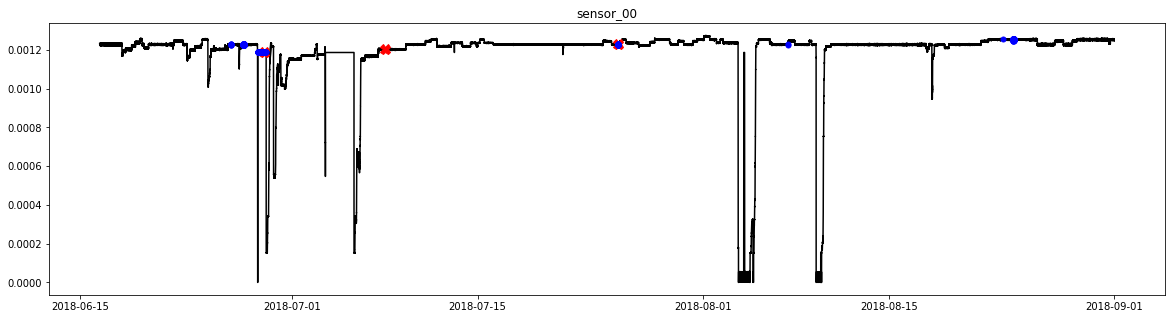

[17880, 30971, 56280]
17.562724014336915
0.0
2.0310633213859015


19.593787335722816

In [34]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 8

- 1 hidden layer
- L1 regularization

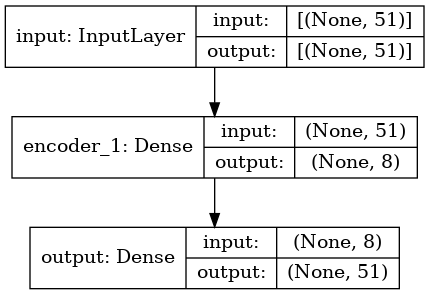

In [35]:
encoder_layer = [
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 955us/step - loss: 0.0770 - val_loss: 0.0092
Epoch 2/80
861/861 [==============================] - 1s 835us/step - loss: 0.0105 - val_loss: 0.0071
Epoch 3/80
861/861 [==============================] - 1s 830us/step - loss: 0.0074 - val_loss: 0.0060
Epoch 4/80
861/861 [==============================] - 1s 796us/step - loss: 0.0058 - val_loss: 0.0052
Epoch 5/80
861/861 [==============================] - 1s 827us/step - loss: 0.0049 - val_loss: 0.0046
Epoch 6/80
861/861 [==============================] - 1s 813us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/80
861/861 [==============================] - 1s 783us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/80
861/861 [==============================] - 1s 819us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/80
861/861 [==============================] - 1s 792us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/80
861/861 [==============================] - 1s 809us/step - loss: 0.002

861/861 [==============================] - 1s 820us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 79/80
861/861 [==============================] - 1s 821us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 80/80
861/861 [==============================] - 1s 872us/step - loss: 0.0010 - val_loss: 0.0018


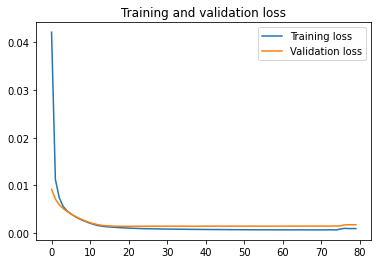

In [36]:
run_model(models[-1], 80, 128, x_train, x_test)

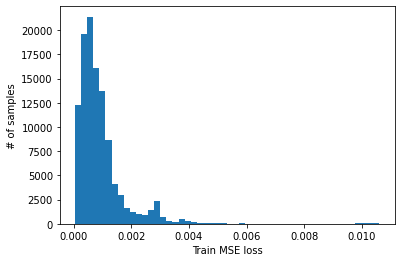

Anomaly MSE threshold:  0.010602674762306669


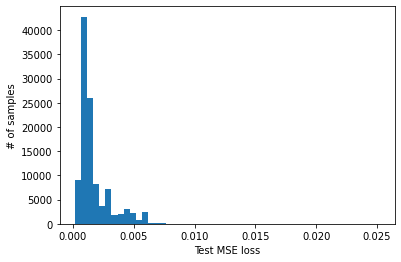

# of anomaly samples:  341
Indices of anomaly samples:  (array([12195, 12196, 12197, 12198, 14260, 14261, 14262, 14263, 14264,
       15611, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620,
       15621, 15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629,
       15630, 15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638,
       15639, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647,
       15648, 15649, 15650, 17190, 17191, 17192, 17203, 17204, 17205,
       17214, 17215, 17216, 17217, 17218, 17399, 17400, 17401, 17402,
       17403, 17430, 17431, 17432, 17433, 17447, 17448, 17449, 17460,
       17461, 17462, 17463, 17468, 17469, 17470, 17471, 17472, 17473,
       17504, 17505, 17506, 17515, 17516, 17517, 17518, 17519, 17524,
       17525, 17526, 17527, 17546, 17547, 17548, 17549, 17550, 17551,
       17552, 17553, 17556, 17557, 17558, 17559, 17560, 17561, 17562,
       17563, 17564, 17729, 17730, 17731, 17735, 17736, 17737, 17738,
       17739, 17740, 17760, 17761

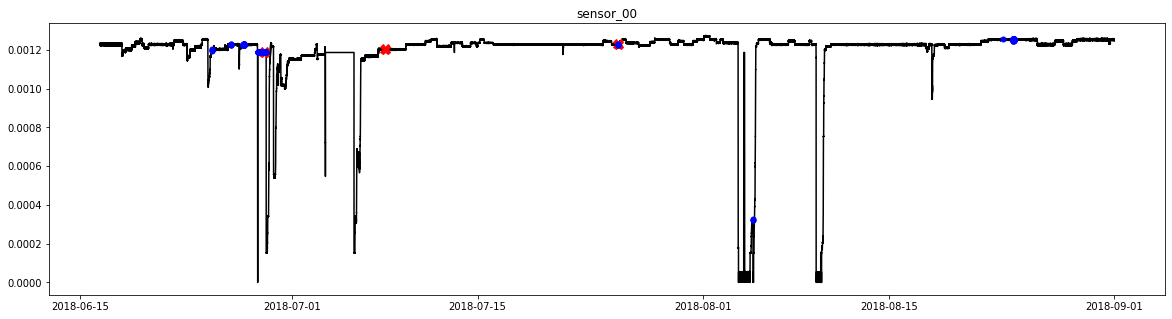

[17880, 30971, 56280]
21.70087976539589
0.0
0.48875855327468226


22.18963831867057

In [37]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 9

- 1 hidden layer
- 2 dropout layers

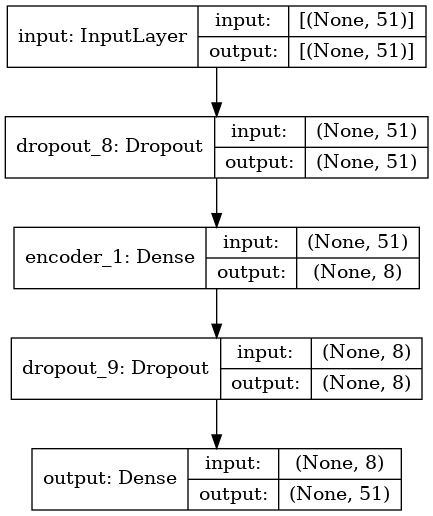

In [38]:
encoder_layer = [
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    )
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 952us/step - loss: 0.0558 - val_loss: 0.0032
Epoch 2/80
861/861 [==============================] - 1s 851us/step - loss: 0.0064 - val_loss: 0.0025
Epoch 3/80
861/861 [==============================] - 1s 845us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 4/80
861/861 [==============================] - 1s 841us/step - loss: 0.0034 - val_loss: 0.0019
Epoch 5/80
861/861 [==============================] - 1s 841us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/80
861/861 [==============================] - 1s 822us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 7/80
861/861 [==============================] - 1s 844us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/80
861/861 [==============================] - 1s 811us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/80
861/861 [==============================] - 1s 803us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/80
861/861 [==============================] - 1s 968us/step - loss: 0.001

861/861 [==============================] - 1s 857us/step - loss: 0.0012 - val_loss: 0.0016


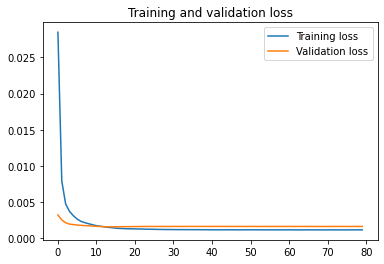

In [39]:
run_model(models[-1], 80, 128, x_train, x_test)

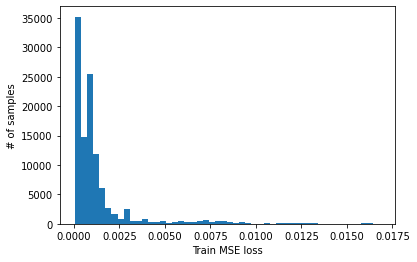

Anomaly MSE threshold:  0.01677548434450749


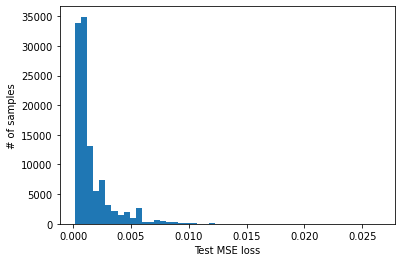

# of anomaly samples:  20
Indices of anomaly samples:  (array([17828, 17829, 17830, 17849, 17850, 17851, 17900, 17901, 17902,
       17903, 17904, 17905, 17909, 17910, 17915, 17916, 17917, 17918,
       17919, 17920]),)


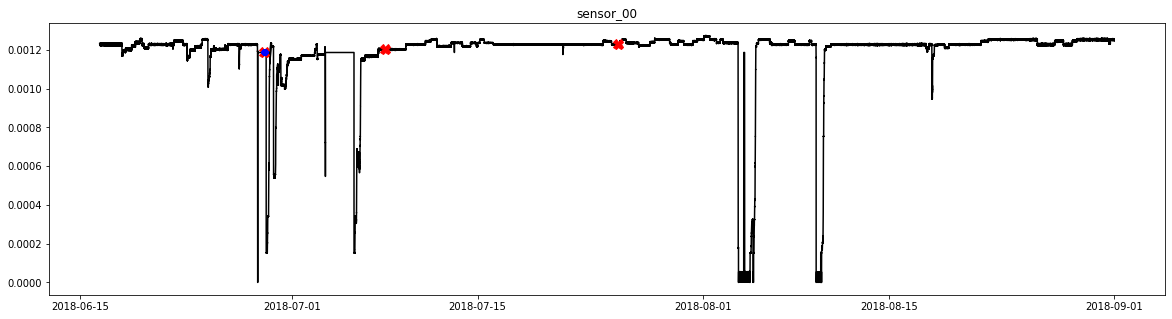

[17880, 30971, 56280]
33.33333333333333
0.0
0.0


33.33333333333333

In [40]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 10

- 1 Hidden layer

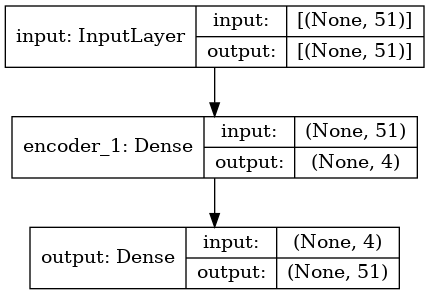

In [41]:
encoder_layer = [
    Dense(
        units=4,
        activation="relu",
#         activity_regularize|r=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.1190 - val_loss: 0.0029
Epoch 2/80
861/861 [==============================] - 1s 905us/step - loss: 0.0060 - val_loss: 0.0026
Epoch 3/80
861/861 [==============================] - 1s 891us/step - loss: 0.0048 - val_loss: 0.0023
Epoch 4/80
861/861 [==============================] - 1s 884us/step - loss: 0.0040 - val_loss: 0.0021
Epoch 5/80
861/861 [==============================] - 1s 883us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/80
861/861 [==============================] - 1s 965us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/80
861/861 [==============================] - 1s 912us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/80
861/861 [==============================] - 1s 921us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/80
861/861 [==============================] - 1s 897us/step - loss: 0.0011 - 

861/861 [==============================] - 1s 902us/step - loss: 7.3851e-04 - val_loss: 0.0015
Epoch 79/80
861/861 [==============================] - 1s 853us/step - loss: 7.3820e-04 - val_loss: 0.0015
Epoch 80/80
861/861 [==============================] - 1s 876us/step - loss: 7.3791e-04 - val_loss: 0.0015


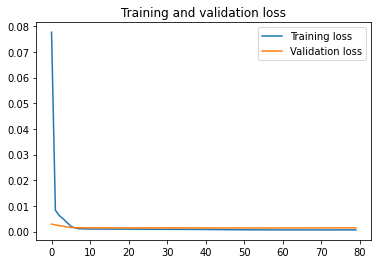

In [42]:
run_model(models[-1], 80, 128, x_train, x_test)

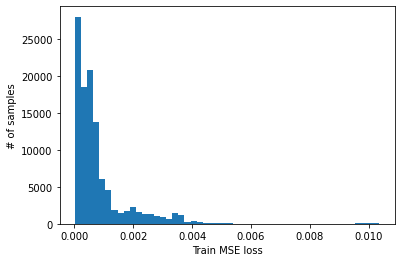

Anomaly MSE threshold:  0.010366482220155399


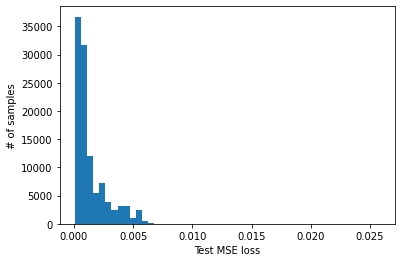

# of anomaly samples:  252
Indices of anomaly samples:  (array([14262, 14263, 14264, 15184, 15185, 15611, 15615, 15616, 15617,
       15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626,
       15627, 15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635,
       15636, 15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644,
       15645, 15646, 15647, 15648, 15649, 15650, 17190, 17191, 17192,
       17203, 17204, 17205, 17209, 17214, 17215, 17216, 17217, 17218,
       17399, 17400, 17401, 17402, 17403, 17430, 17431, 17432, 17433,
       17447, 17448, 17449, 17458, 17459, 17460, 17461, 17462, 17463,
       17464, 17468, 17469, 17470, 17471, 17472, 17473, 17481, 17482,
       17483, 17484, 17485, 17504, 17505, 17506, 17514, 17515, 17516,
       17517, 17518, 17519, 17524, 17525, 17526, 17527, 17546, 17547,
       17548, 17549, 17550, 17551, 17552, 17553, 17557, 17558, 17559,
       17560, 17561, 17562, 17563, 17564, 17729, 17730, 17731, 17735,
       17736, 17737, 17738, 17739

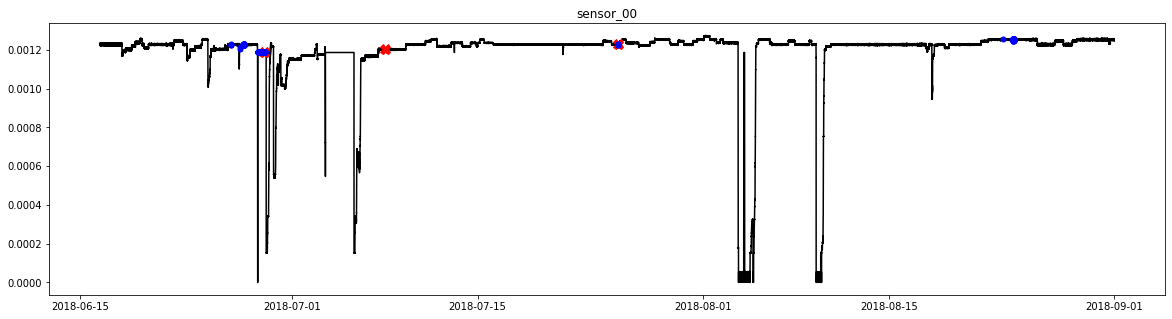

[17880, 30971, 56280]
18.65079365079365
0.0
0.529100529100529


19.179894179894177

In [43]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 11

- 1 hidden layer
- Reg term L1

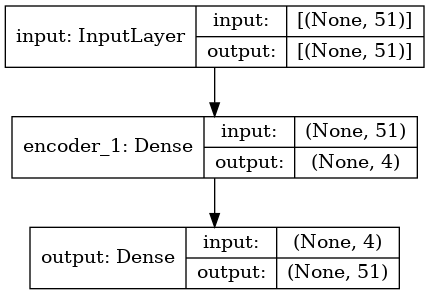

In [44]:
encoder_layer = [
    Dense(
        units=4,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-4),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0866 - val_loss: 0.0048
Epoch 2/80
861/861 [==============================] - 1s 891us/step - loss: 0.0071 - val_loss: 0.0034
Epoch 3/80
861/861 [==============================] - 1s 904us/step - loss: 0.0048 - val_loss: 0.0027
Epoch 4/80
861/861 [==============================] - 1s 982us/step - loss: 0.0031 - val_loss: 0.0022
Epoch 5/80
861/861 [==============================] - 1s 987us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/80
861/861 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/80
861/861 [==============================] - 1s 890us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/80
861/861 [==============================] - 1s 901us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/80
861/861 [==============================] - 1s 909us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 10/80
861/861 [==============================] - 1s 878us/step - loss: 0.0015 - 

861/861 [==============================] - 1s 880us/step - loss: 7.7334e-04 - val_loss: 0.0016
Epoch 79/80
861/861 [==============================] - 1s 878us/step - loss: 7.7278e-04 - val_loss: 0.0016
Epoch 80/80
861/861 [==============================] - 1s 898us/step - loss: 7.7346e-04 - val_loss: 0.0016


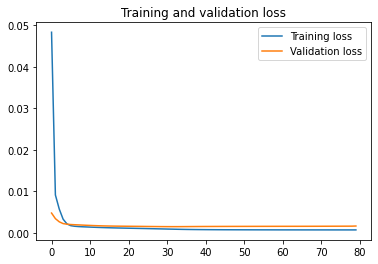

In [45]:
run_model(models[-1], 80, 128, x_train, x_test)

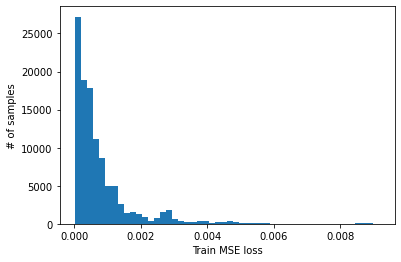

Anomaly MSE threshold:  0.009168654898290734


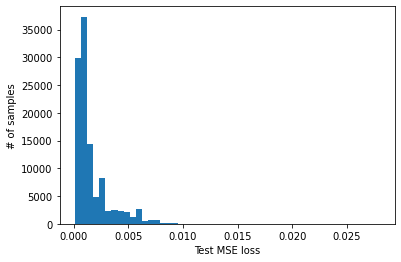

# of anomaly samples:  342
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 14266, 14267, 15183, 15184,
       15185, 15186, 15187, 15604, 15605, 15606, 15607, 15608, 15609,
       15610, 15611, 15612, 15613, 15614, 15615, 15616, 15617, 15618,
       15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626, 15627,
       15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635, 15636,
       15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644, 15645,
       15646, 15647, 15648, 15649, 15650, 17190, 17191, 17192, 17203,
       17204, 17205, 17209, 17210, 17214, 17215, 17216, 17217, 17218,
       17220, 17221, 17222, 17223, 17224, 17225, 17399, 17400, 17401,
       17402, 17403, 17430, 17431, 17432, 17433, 17447, 17448, 17449,
       17458, 17459, 17460, 17461, 17462, 17463, 17464, 17468, 17469,
       17470, 17471, 17472, 17473, 17481, 17482, 17483, 17484, 17485,
       17504, 17505, 17506, 17514, 17515, 17516, 17517, 17518, 17519,
       17524, 17525, 17526, 17527

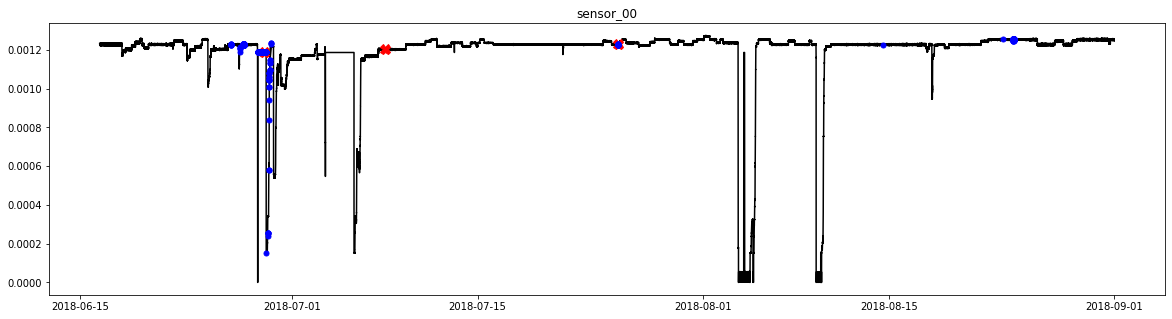

[17880, 30971, 56280]
19.78557504873294
0.0
0.9746588693957113


20.76023391812865

In [46]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)